In [35]:
from qiskit import *
import numpy as np
from qiskit import IBMQ

token='a2afa69f70955de3c84068e58c44bd81e01740c07ff40db7e9ab824c0da8b9412da7a86e9c453f7f97ecc35fc9f09948ce053cbd9e8213b98feadba15dcc467f'
#IBMQ.enable_account(token)
IBMQ.save_account(token,overwrite=True)
IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-ornl',group='ornl',project='csc517')
#backend = provider.get_backend('ibm_hanoi')
#backend_config = backend.configuration()

ibmqfactory.load_account:WARNING:2023-05-31 14:23:43,994: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

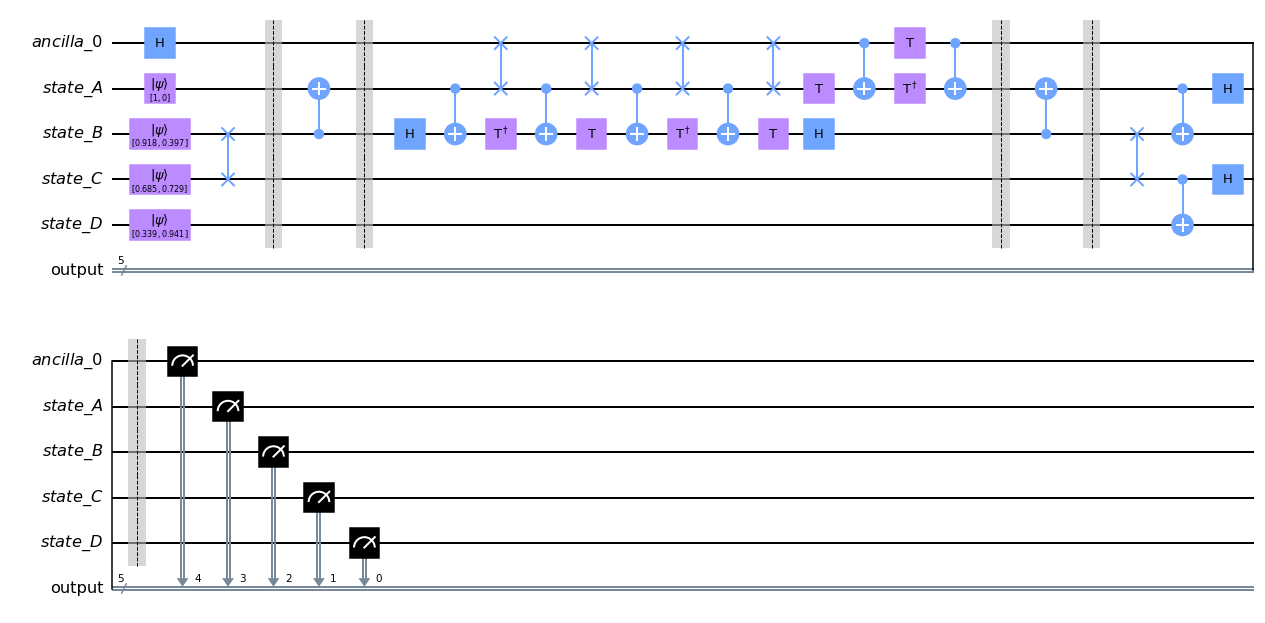

In [98]:

ancilla = QuantumRegister(1, 'ancilla_0')
A = QuantumRegister(1,'state_A')
B = QuantumRegister(1,'state_B')
C = QuantumRegister(1,'state_C')
D = QuantumRegister(1,'state_D')
Meas = ClassicalRegister(5,'output')

circuit = QuantumCircuit(ancilla, A, B, C, D, Meas)

angle = 0.26
for i in range(0,4):
    circuit.initialize([np.cos(i*angle*np.pi/2),np.sin(i*angle*np.pi/2)],i+1)

circuit.h(0)

#circuit.cswap(0,1,3) This is getting replaced by:

circuit.swap(2,3) #an initial swap will minimize future swaps during the Toffoli decomposition
circuit.barrier()
circuit.cx(2,1)
circuit.barrier()
### Decomposed Toffoli, using swaps instead of CNOT gates operating on separated qubits
circuit.h(2)
circuit.cx(1,2)
circuit.tdg(2)
circuit.swap(0,1)
circuit.cx(1,2)
circuit.swap(0,1)
circuit.t(2)
circuit.cx(1,2)
circuit.tdg(2)
circuit.swap(0,1)
circuit.cx(1,2)
circuit.swap(0,1)
circuit.t(1)
circuit.t(2)
circuit.h(2)
circuit.cx(0,1)
circuit.t(0)
circuit.tdg(1)
circuit.cx(0,1)
###
circuit.barrier()
circuit.cx(2,1)

#correcting swap and final gates needed for Bell measurement
circuit.barrier()
circuit.swap(2,3)
circuit.cx(1,2)
circuit.cx(3,4)
circuit.h(1)
circuit.h(3)

circuit.barrier()

for i in range(0,5):
    circuit.measure(i,4-i)

circuit.draw(output='mpl')

In [116]:
shots = 10000
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit,simulator,shots=shots)

result = job.result()
counts = result.get_counts(circuit)

r12 = 1-4*(counts.get('01100',0)+counts.get('01101',0)+counts.get('01110',0)+counts.get('01111',0))/shots
print(f"r_12 = {r12}")
r23 = 1-4*(counts.get('11100',0)+counts.get('11101',0)+counts.get('11110',0)+counts.get('11111',0))/shots
print(f"r_23 = {r23}")
r34 = 1-4*(counts.get('00011',0)+counts.get('00111',0)+counts.get('01011',0)+counts.get('01111',0))/shots
print(f"r_34 = {r34}")
r14 = 1-4*(counts.get('10011',0)+counts.get('10111',0)+counts.get('11011',0)+counts.get('11111',0))/shots
print(f"r_14 = {r14}")

inequality = r12 + r23 + r34 - r14

print(f"r_12 + r_23 + r_34 - r_14 = {inequality}")

r_12 = 0.6728000000000001
r_23 = 0.6632
r_34 = 0.6816
r_14 = -0.8184
r_12 + r_23 + r_34 - r_14 = 2.836


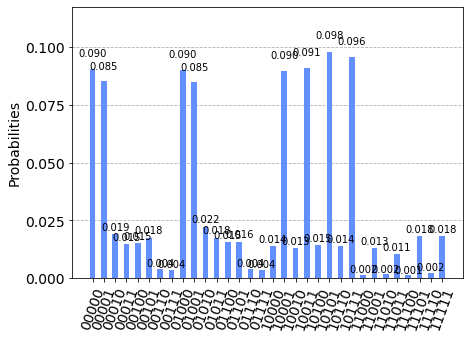

In [103]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [151]:
from qiskit import pulse
provider = IBMQ.get_provider(hub='ibm-q-ornl',group='ornl',project='csc517')
backend = provider.get_backend('ibmq_guadalupe')
config = backend.configuration()

GHz = 1.0e9
MHz = 1.0e6
us = 1.0e-6
ns = 1.0e-9

dt = config.dt
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']
backend_defaults = backend.defaults()

print("This backend is called {0}, and is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates))

RequestsApiError: '401 Client Error: Unauthorized for url: https://api-qcon.quantum-computing.ibm.com/api/Network/ibm-q-ornl/Groups/ornl/Projects/csc517/devices/ibmq_guadalupe/defaults. Authorization Required, Error code: 2407.'

In [150]:
def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    # Conversion factors from standard SI units
    us = 1e6
    ns = 1e9
    GHz = 1e-9

    print("Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('sx', qubit),
              properties.gate_length('sx', qubit) * ns,
              properties.frequency(qubit) * GHz))

In [132]:
props = backend.properties()
describe_qubit(0, props)

Qubit 0 has a 
  - T1 time of 370.4369769190703 microseconds
  - T2 time of 193.0827623462623 microseconds
  - U2 gate error of 0.0001848532089147639
  - U2 gate duration of 56.888888888888886 nanoseconds
  - resonant frequency of 4.635654075476614 GHz


In [144]:
from qiskit.pulse import Schedule
from qiskit.pulse import Gaussian

# qubits used:
qubit0 = 0
qubit1 = 1
qubit2 = 2
qubit3 = 3
qubit4 = 4

ancilla = QuantumRegister(1, 'ancilla_0')
A = QuantumRegister(1,'state_A')
B = QuantumRegister(1,'state_B')
C = QuantumRegister(1,'state_C')
D = QuantumRegister(1,'state_D')
Meas = ClassicalRegister(5,'output')

pulse_circuit = QuantumCircuit(ancilla, A, B, C, D, Meas)

schedule = Schedule(name="4_state_Bell_measurement")

# https://qiskit.org/documentation/tutorials/circuits_advanced/05_pulse_gates.html
with pulse.build(backend, name='hadamard') as h_q0:
    pulse.play(Gaussian(duration=128, amp=0.1,sigma=16), pulse.drive_channel(qubit0))
with pulse.build(backend, name='hadamard') as h_q1:
    pulse.play(Gaussian(duration=128, amp=0.1,sigma=16), pulse.drive_channel(qubit1))
with pulse.build(backend, name='hadamard') as h_q2:
    pulse.play(Gaussian(duration=128, amp=0.1,sigma=16), pulse.drive_channel(qubit2))
with pulse.build(backend, name='hadamard') as h_q3:
    pulse.play(Gaussian(duration=128, amp=0.1,sigma=16), pulse.drive_channel(qubit3))

pulse_circuit.add_calibration('h',[qubit0],h_q0)
pulse_circuit.add_calibration('h',[qubit1],h_q1)
pulse_circuit.add_calibration('h',[qubit2],h_q2)
pulse_circuit.add_calibration('h',[qubit3],h_q3)

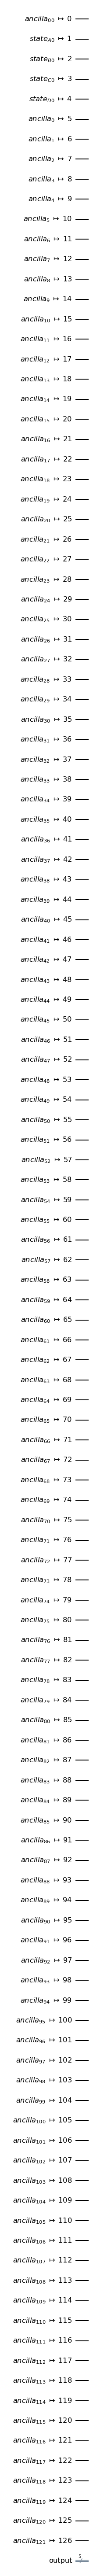

In [146]:
from qiskit import transpile
circuit = transpile(pulse_circuit, backend)
circuit.draw('mpl')